In [47]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plots.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/closed_loop.py



In [1]:
%%capture output
!unzip Model.zip

In [63]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

from closed_loop import closed_loop
from plots import plot_raster, plot_times_series, plot_joints, read_sto

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start Simulation :
EES frequency : 50. Hz
Number Ia fibers recruited by EES: 60 / 60
Number II fibers recruited by EES : 60 / 60
Number Efferent fibers recruited by EES : 0 / 169
--- Iteration 1 of 2 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 169/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 2 of 2 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 169/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
Setting muscles to resting state
results/All_opensim_Ia_60_II_60_Moto_0_Freq_50. Hz.sto file is saved




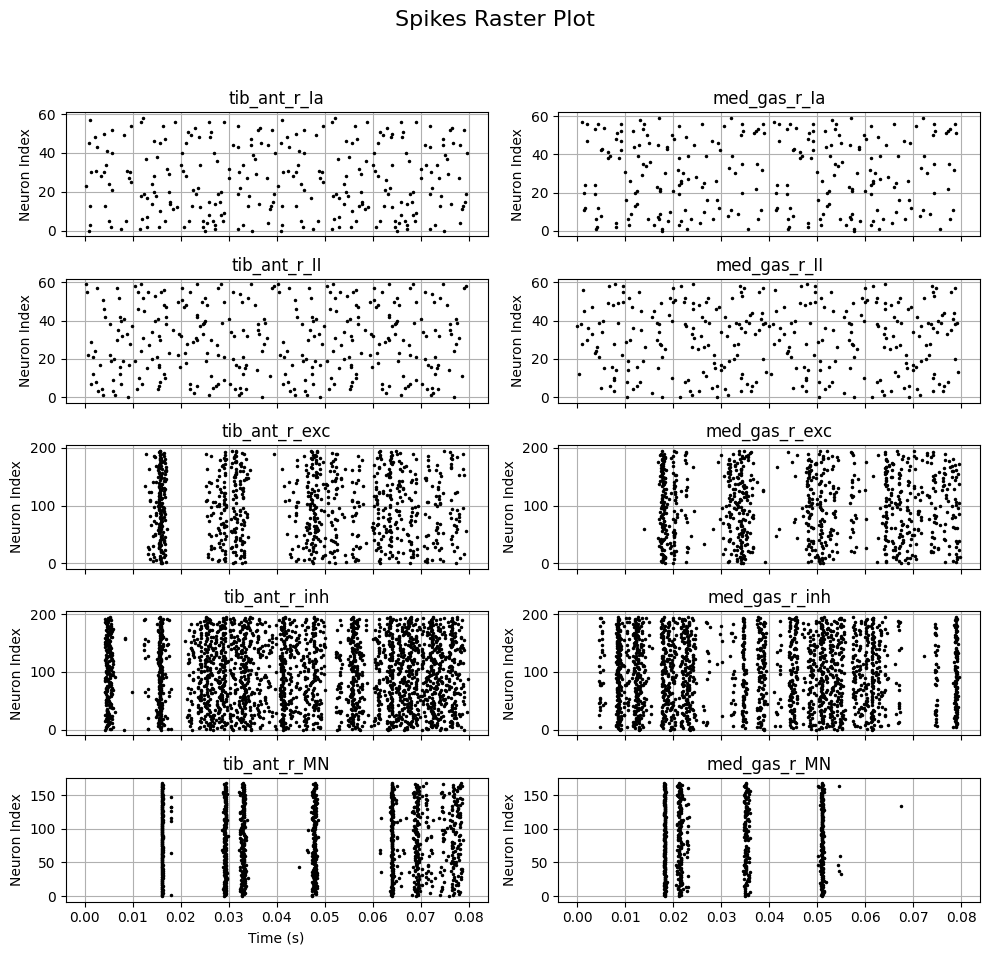

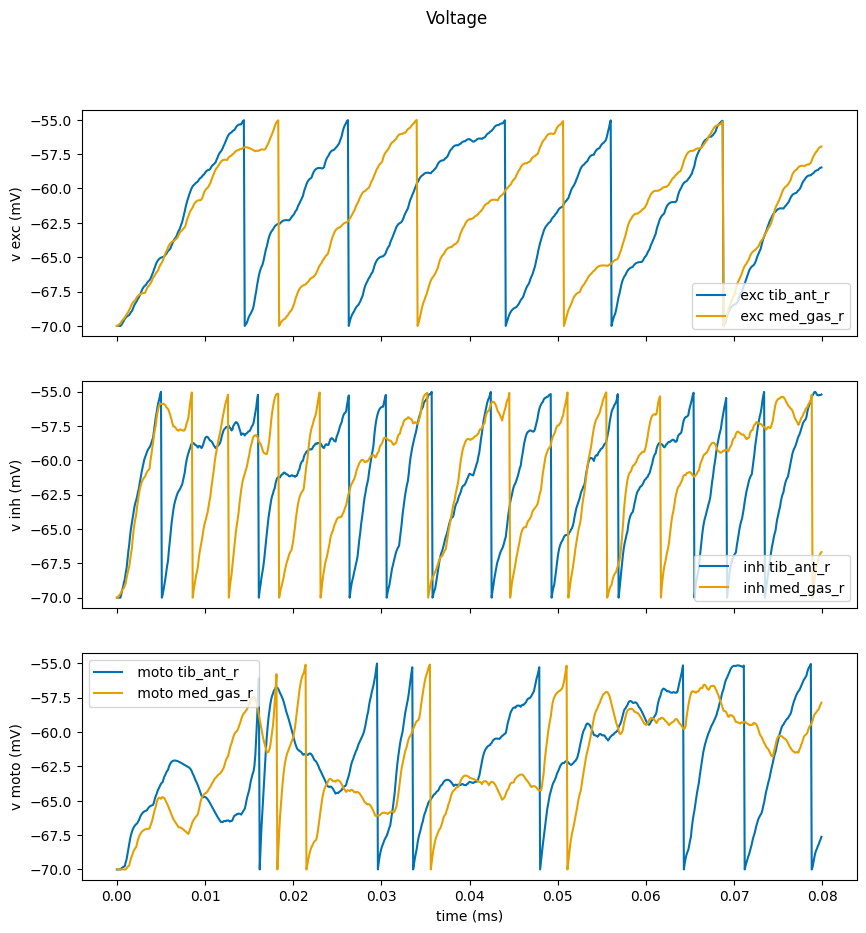

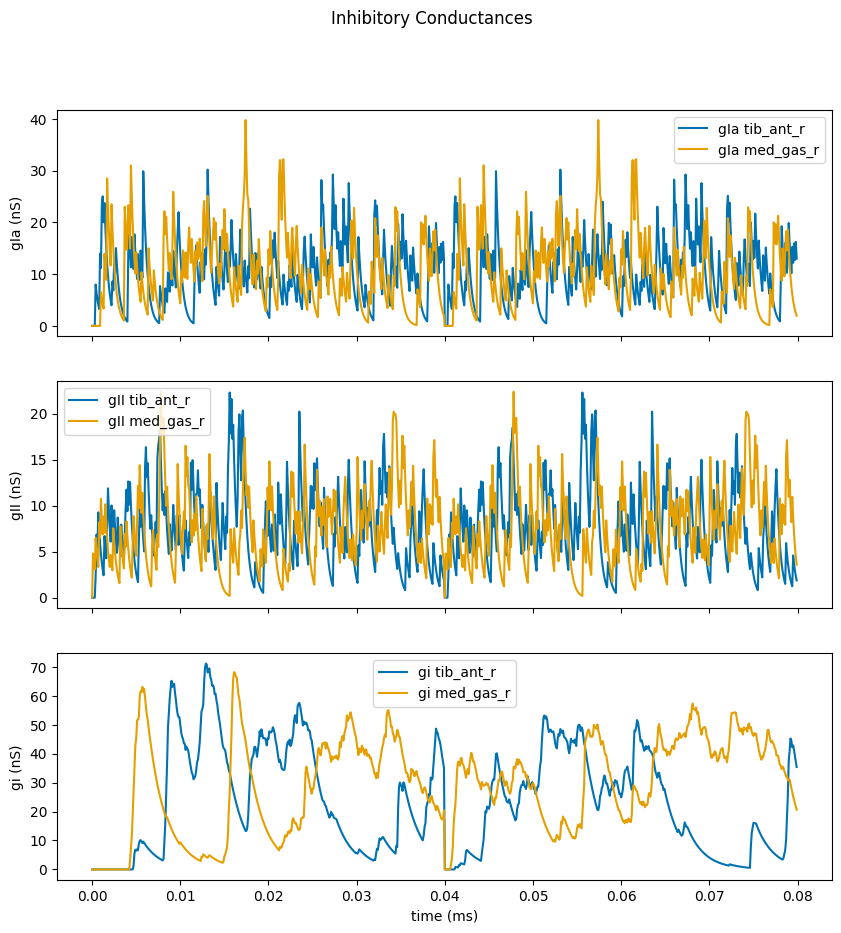

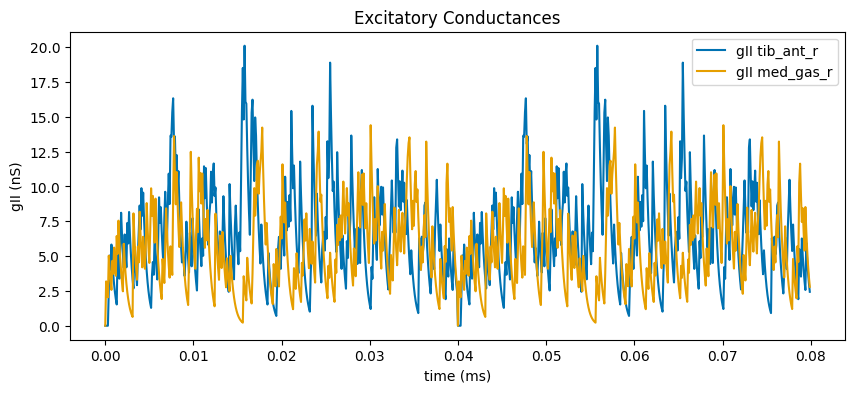

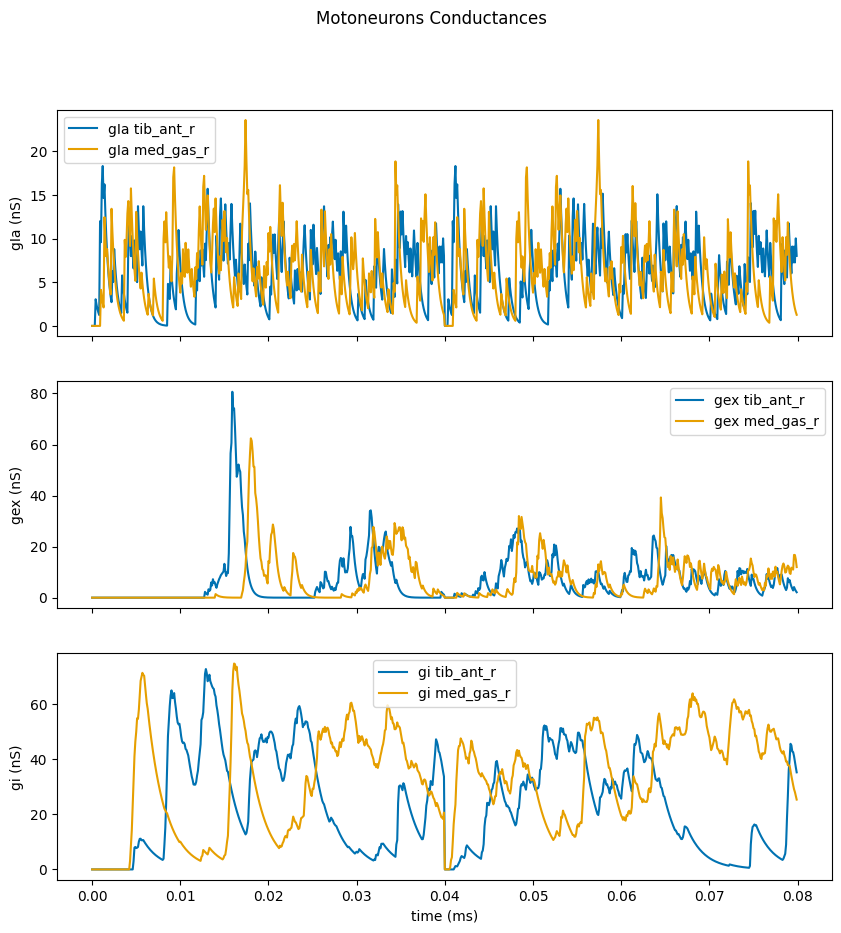

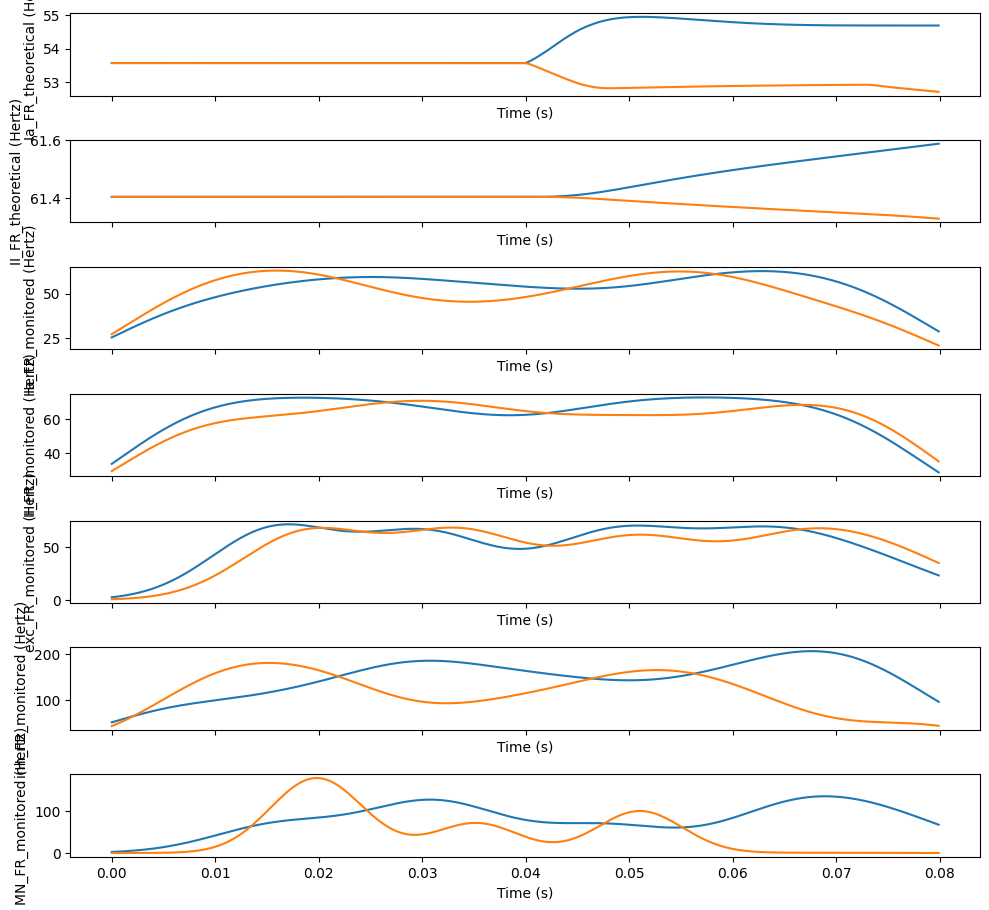

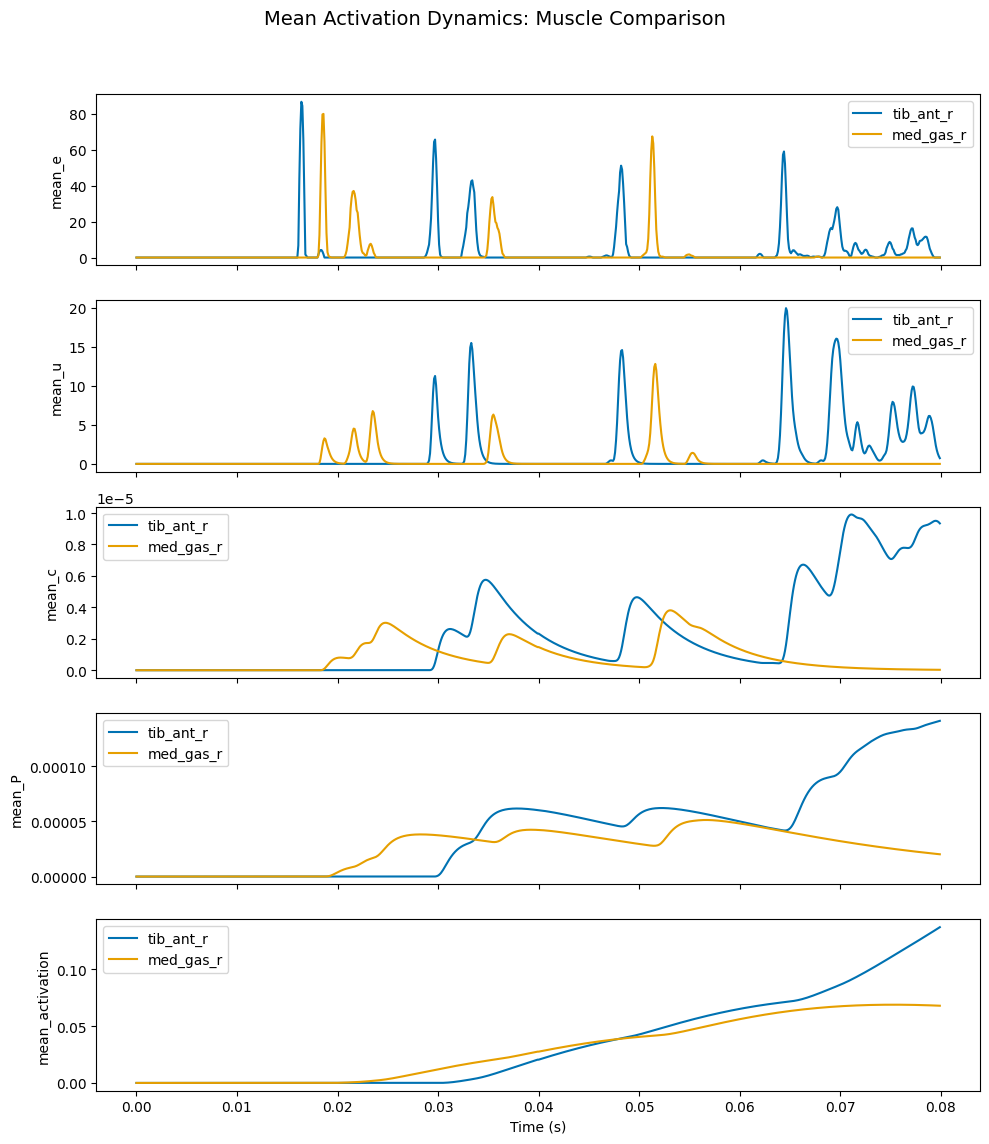

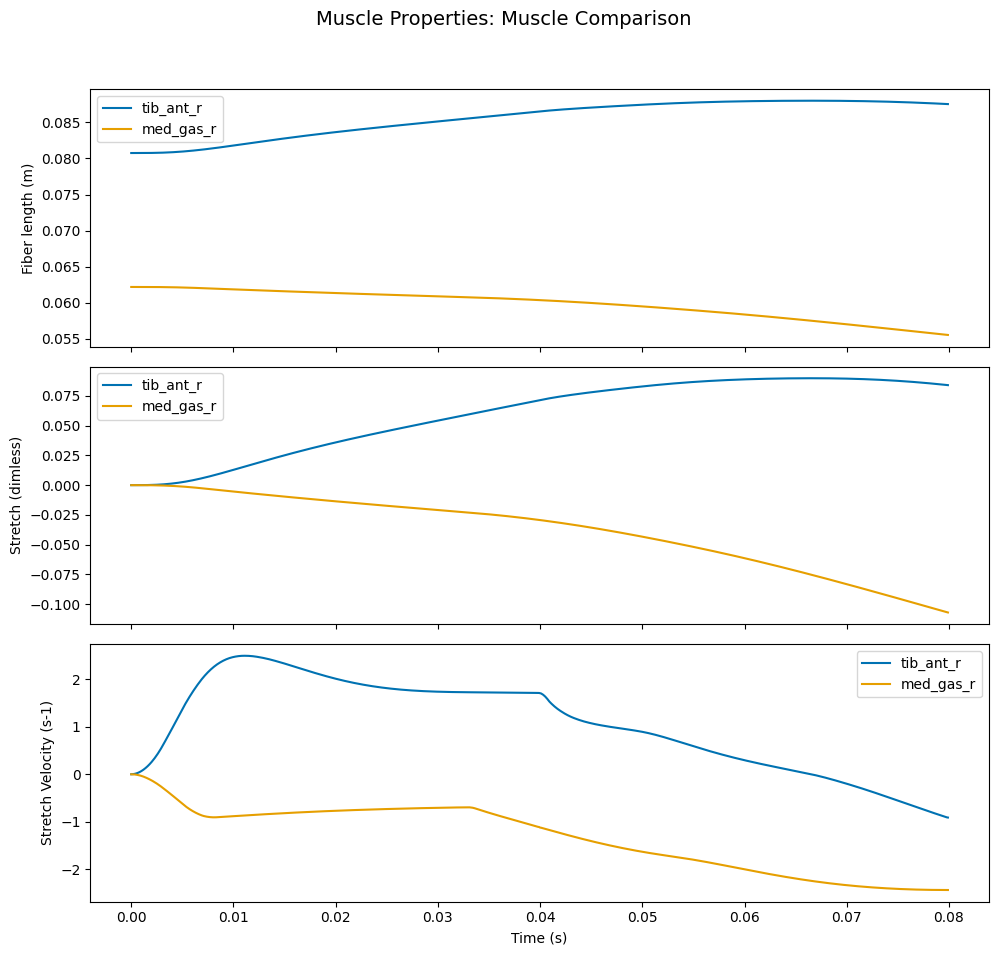

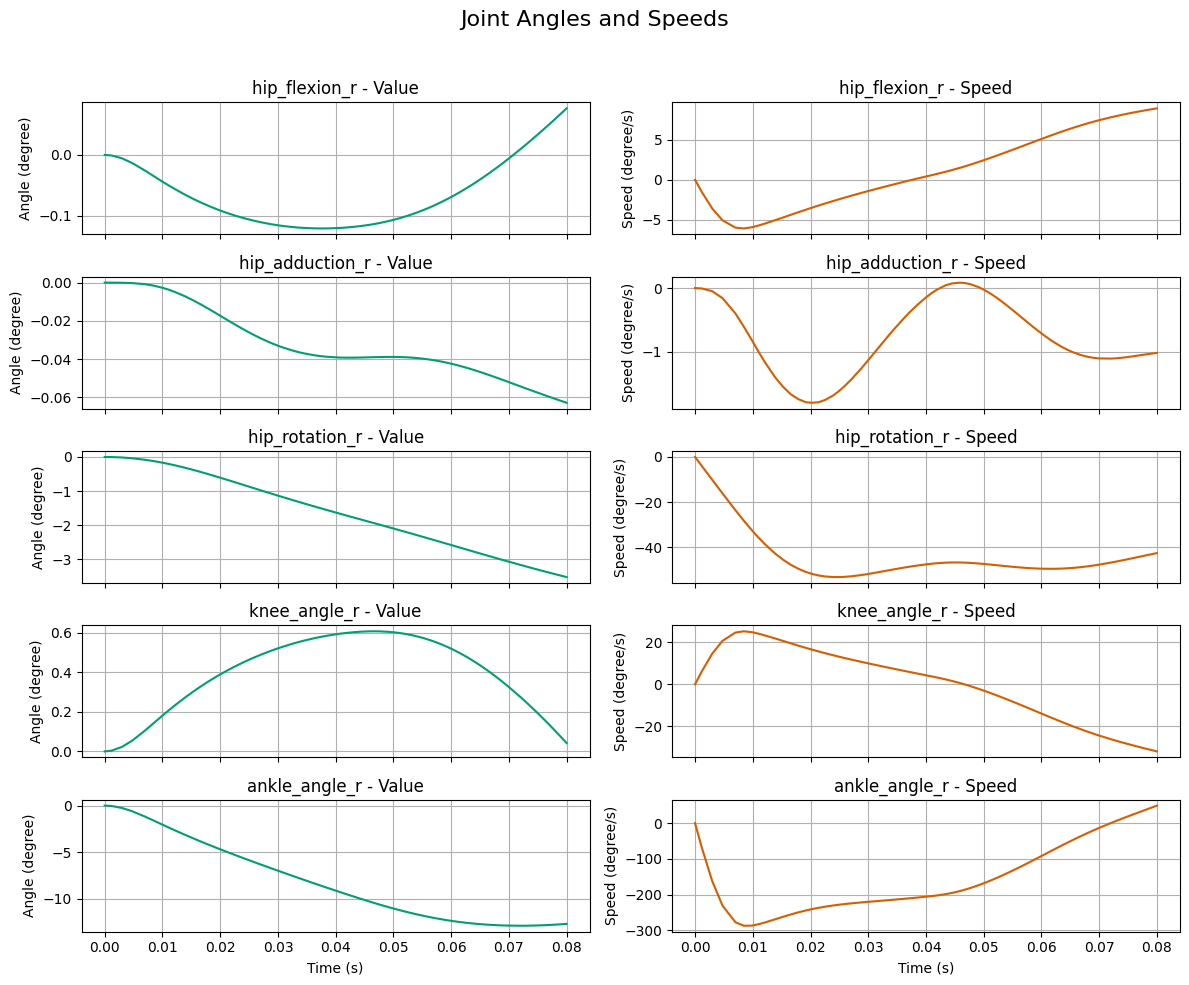

In [60]:
NEURON_COUNTS = {
      "Ia": 60,       # Type Ia afferent neurons
      "II": 60,       # Type II afferent neurons
      "inh": 196,     # Inhibitory interneurons
      "exc": 196,     # Excitatory interneurons
      "motor": 169    # Motor neurons
}

EES_PARAMS = {
    'ees_freq': 50 * hertz,      # Frequency of epidural electrical stimulation
    'Ia_recruited': 60,     # Number of Ia fibers recruited
    'II_recruited': 60,     # Number of II fibers recruited
    'eff_recruited': 0       # Number of efferent fibers recruited
}
CONNECTIONS = {
    # Maintain sensory input connections
    ("Ia_flexor", "moto_flexor"): {"w": 2*2.1*nS, "p": 0.9},
    ("Ia_flexor", "inh_flexor"): {"w": 2*3.64*nS, "p": 0.9},
    ("Ia_extensor", "moto_extensor"): {"w": 2*2.1*nS, "p": 0.9},
    ("Ia_extensor", "inh_extensor"): {"w": 2*3.64*nS, "p": 0.9},

    ("II_flexor", "exc_flexor"): {"w": 2*1.65*nS, "p": 0.9},
    ("II_flexor", "inh_flexor"): {"w": 2*2.19*nS, "p": 0.9},
    ("II_extensor", "exc_extensor"): {"w": 2*1.65*nS, "p": 0.9},
    ("II_extensor", "inh_extensor"): {"w": 2*2.19*nS, "p": 0.9},

    # Increase excitatory drive to promote activity
    ("exc_flexor", "moto_flexor"): {"w": 2*0.9*nS, "p": 0.7},     # Increased from 0.7
    ("exc_extensor", "moto_extensor"): {"w": 2*0.9*nS, "p": 0.7},  # Increased from 0.7

    # Modify reciprocal inhibition to create time-limited inhibition
    ("inh_flexor", "moto_extensor"): {"w": 2*0.3*nS, "p": 0.9},    # Moderate inhibition
    ("inh_extensor", "moto_flexor"): {"w": 2*0.3*nS, "p": 0.9},    # Moderate inhibition

    # Create cross-excitatory connections for rebound activation
    ("inh_flexor", "inh_extensor"): {"w": 2*0.4*nS, "p": 0.6},     # Reduced from 0.75
    ("inh_extensor", "inh_flexor"): {"w": 2*0.4*nS, "p": 0.6},     # Reduced from 0.75

}
equation_Ia = "10+ 0.4*stretch + 1*sign(velocity)*abs(velocity)**0.6"
equation_II="20 + 3.375*stretch"

BIOPHYSICAL_PARAMS = {
    'T_refr': 2 * ms,  # Refractory period
    'Eleaky':-70*mV,
    'gL':10*nS,
    'Cm':0.3*nF,
    'E_ex':0*mV,
    'E_inh':-75*mV,
    'tau_e':0.5*ms,
    'tau_1':2*ms,
    'tau_2':4.5*ms,
    'threshold_v':-55*mV
}

N_ITERATIONS = 2      # Number of iterations
seed=41
REACTION_TIME = 40 * ms  # Duration of each simulation iteration
TIME_STEP = 0.1 * ms     # Simulation time step

MUSCLES_STR= "tib_ant_r,med_gas_r"  # Comma-separated muscle names
muscles_names=MUSCLES_STR.split(',')

# Create directory to save STO FILE
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
sto_name = f'All_opensim_' \
            f'Ia_{EES_PARAMS["Ia_recruited"]}_' \
            f'II_{EES_PARAMS["II_recruited"]}_' \
            f'Moto_{EES_PARAMS["eff_recruited"]}_' \
            f'Freq_{EES_PARAMS["ees_freq"]}_'\
            f'{timestamp}_'\
            f'{seed}.sto'
sto_path = os.path.join(RESULTS_DIR, sto_name)

spikes, muscles=closed_loop(
        N_ITERATIONS, REACTION_TIME, TIME_STEP, EES_PARAMS, NEURON_COUNTS, CONNECTIONS,
        equation_Ia, equation_II, BIOPHYSICAL_PARAMS,
        MUSCLES_STR,sto_path, seed=seed)

plot_raster(spikes,RES_DIR,**EES_PARAMS )
plot_times_series(muscles,muscles_names,RES_DIR,**EES_PARAMS )
JOINT_COLUMNS = [
      "hip_flexion_r",
      "hip_adduction_r",
      "hip_rotation_r",
      "knee_angle_r",
      "ankle_angle_r",
      ]
plot_joints(sto_path, JOINT_COLUMNS,RES_DIR,**EES_PARAMS )

Start Simulation :
EES frequency : 30. Hz
Number Ia fibers recruited by EES: 60 / 60
Number II fibers recruited by EES : 60 / 60
Number Efferent fibers recruited by EES : 0 / 169
--- Iteration 1 of 5 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 169/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 2 of 5 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 164/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 3 of 5 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 6/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 4 of 5 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 5/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

--- Iteration 5 of 5 ---
Number of flexor recruited motoneuron: 169/169
Number of extensor recruited motoneuron: 4/169


Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

Processing motoneurons:   0%|          | 0/169 [00:00<?, ?it/s]

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
Setting muscles to resting state
frequency_analysis/All_opensim_Ia_60_II_60_Moto_0_Freq_30. Hz_20250508_155858_41.sto file is saved


Saved plot: Ia-FR-theoretical_30to30Hz_20250508_160034_41.png
Saved plot: II-FR-theoretical_30to30Hz_20250508_160034_41.png
Saved plot: IPSP-inh_30to30Hz_20250508_160034_41.png
Saved plot: IPSP-moto_30to30Hz_20250508_160034_41.png
Saved plot: recruited-MN_30to30Hz_20250508_160034_41.png
Saved plot: MN-FR-monitored_30to30Hz_20250508_160034_41.png
Saved plot: mean-activation_30to30Hz_20250508_160034_41.png
Saved plot: stretch_30to30Hz_20250508_160034_41.png
Saved plot: joints_30to30Hz_20250508_160034_41.png


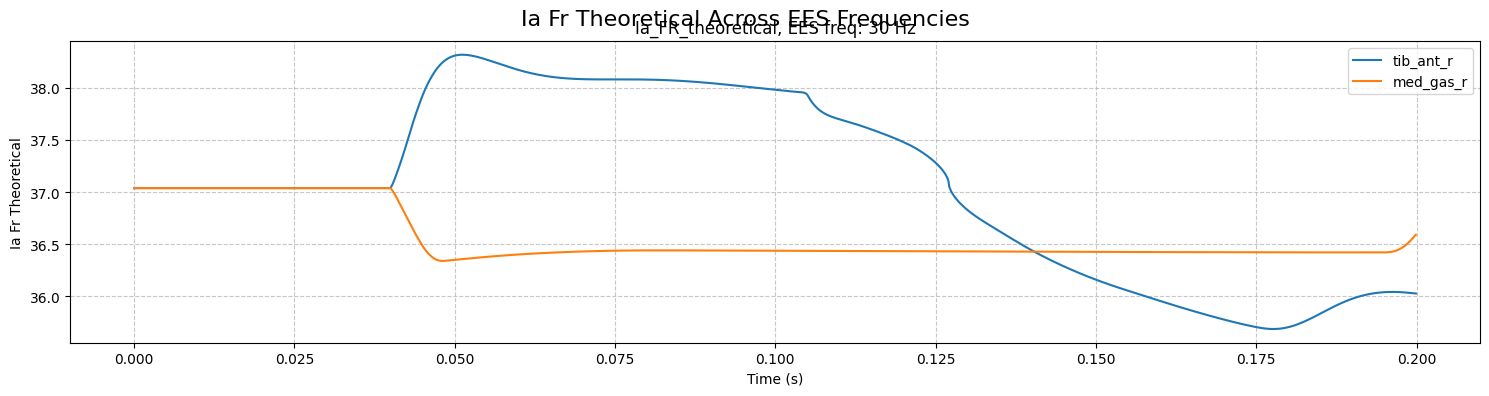

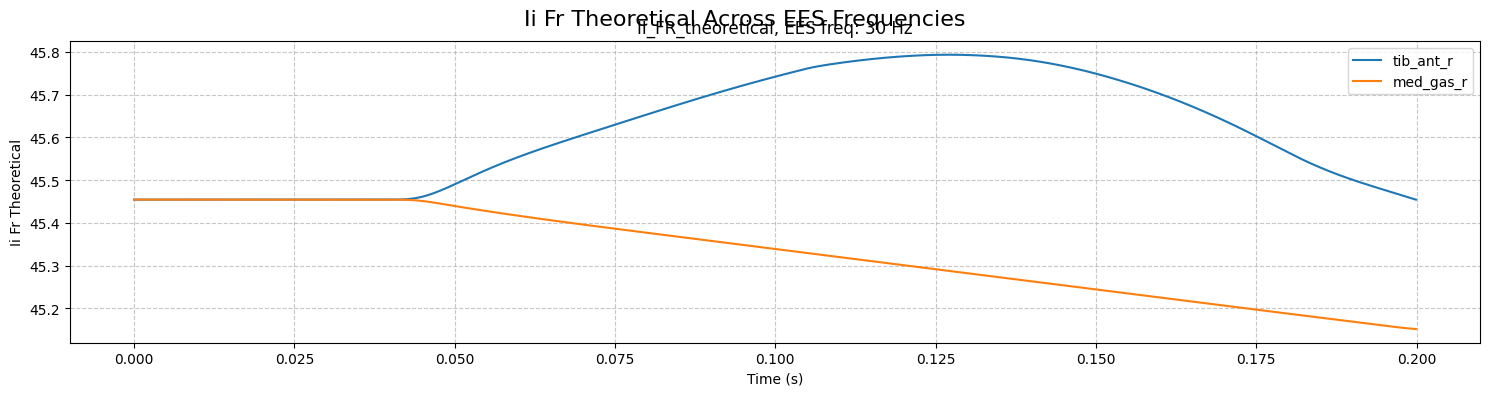

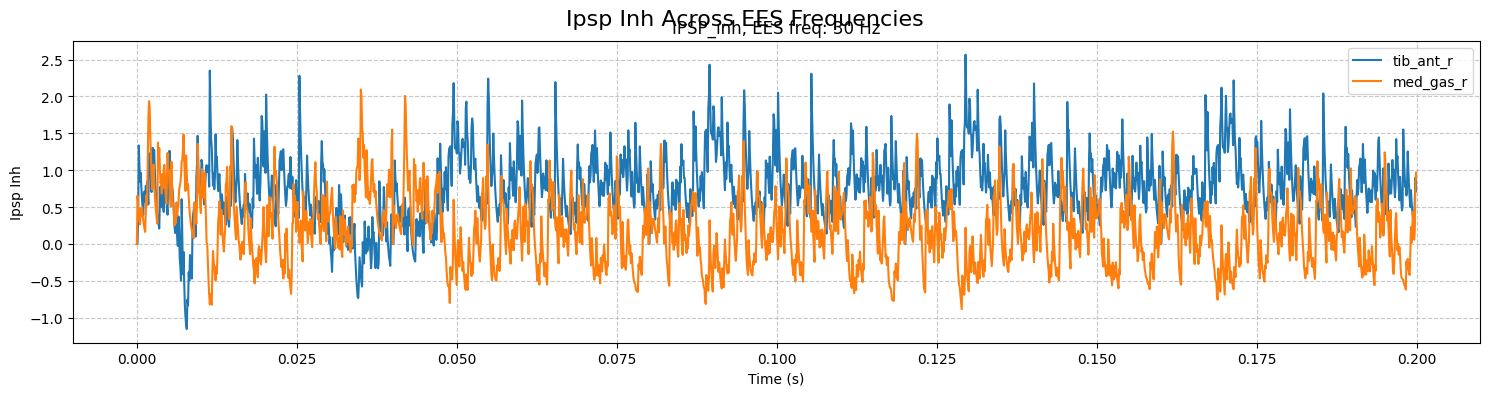

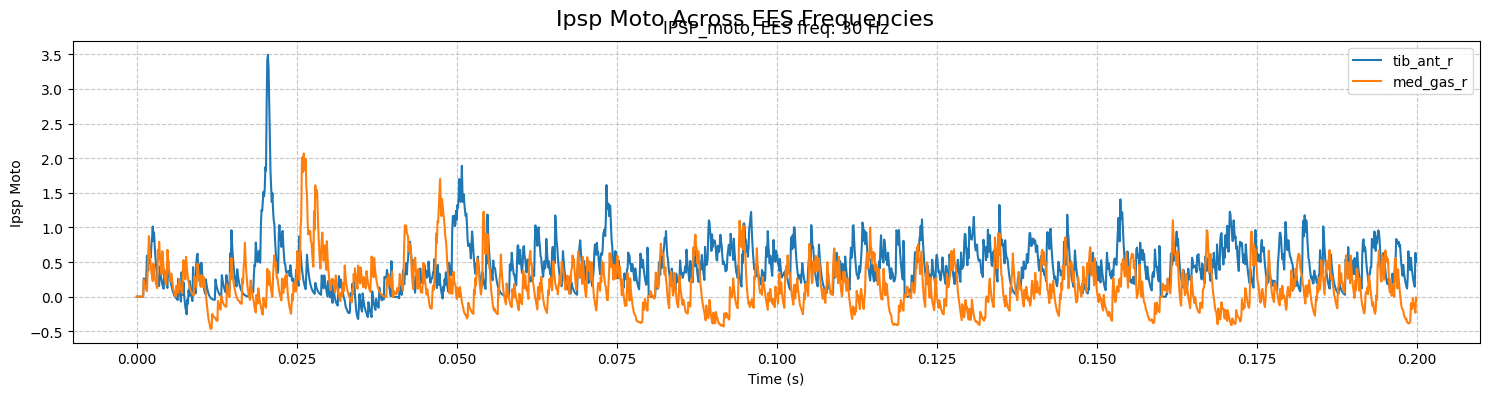

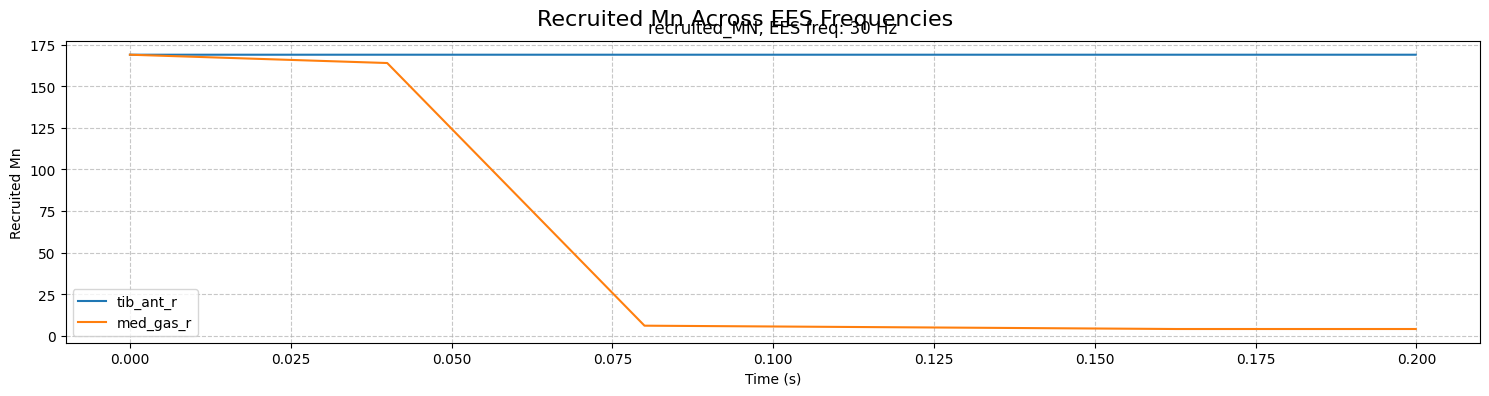

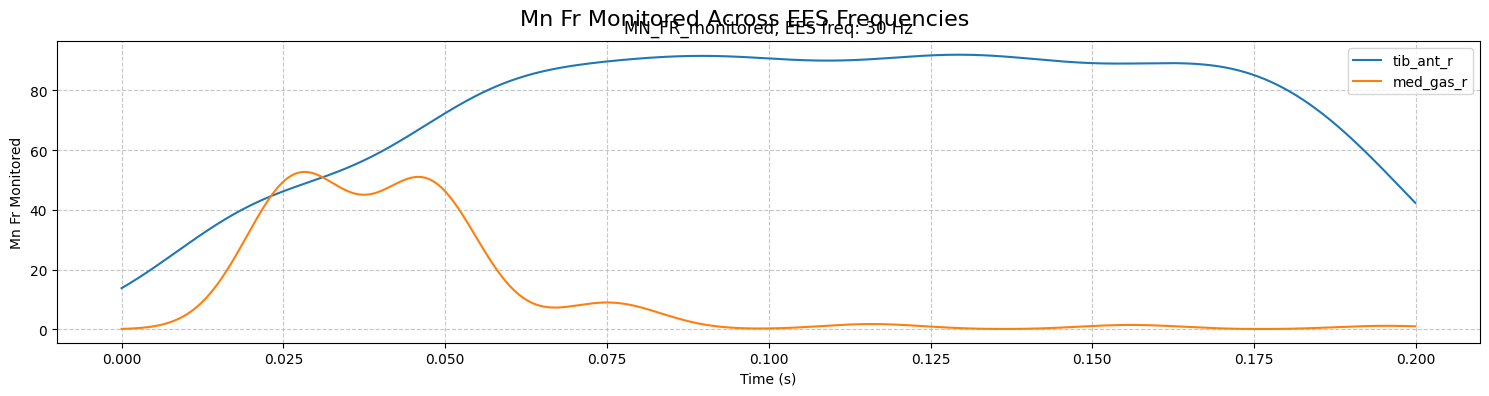

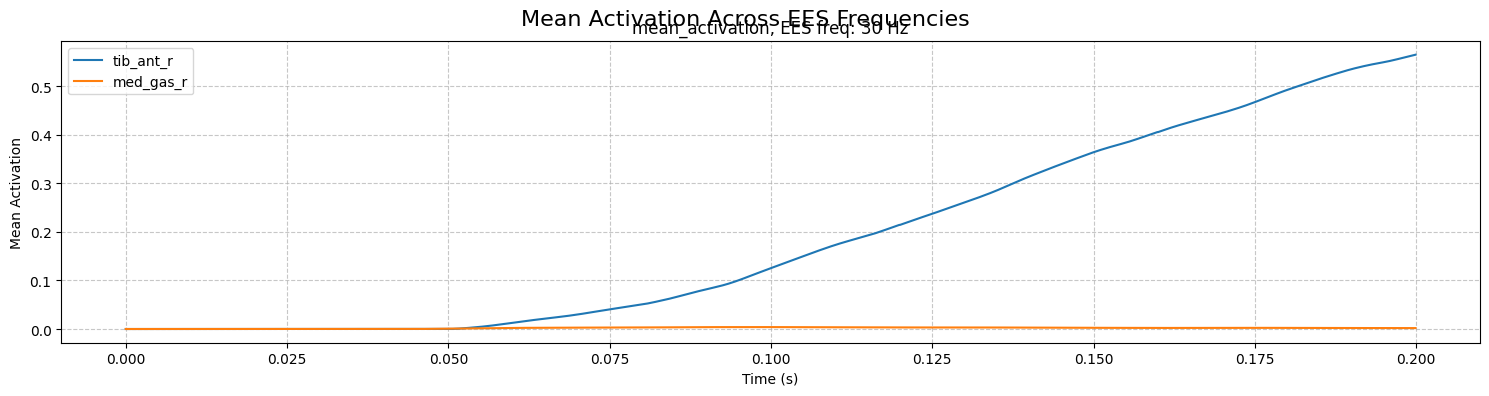

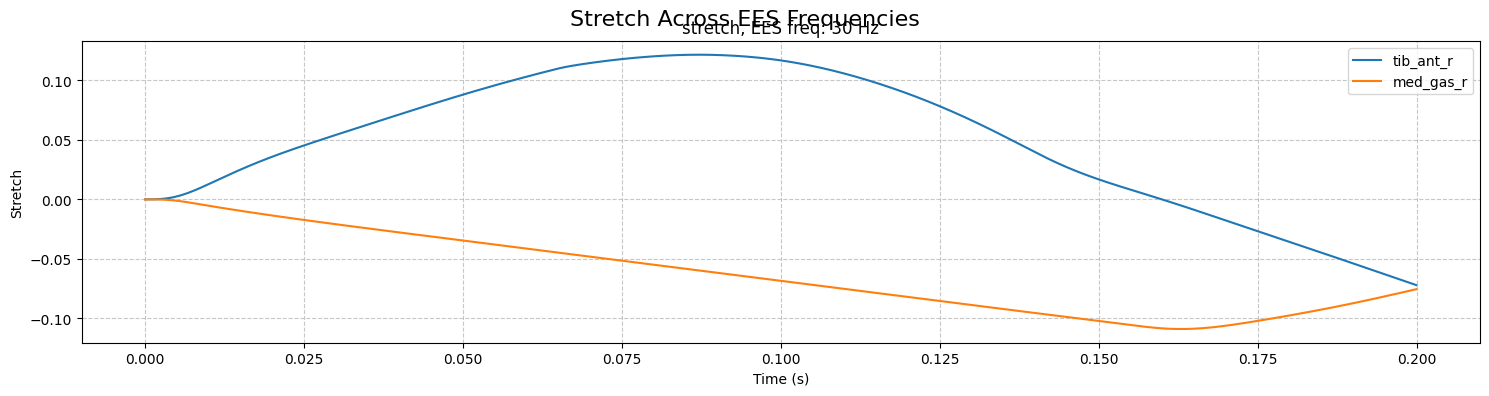

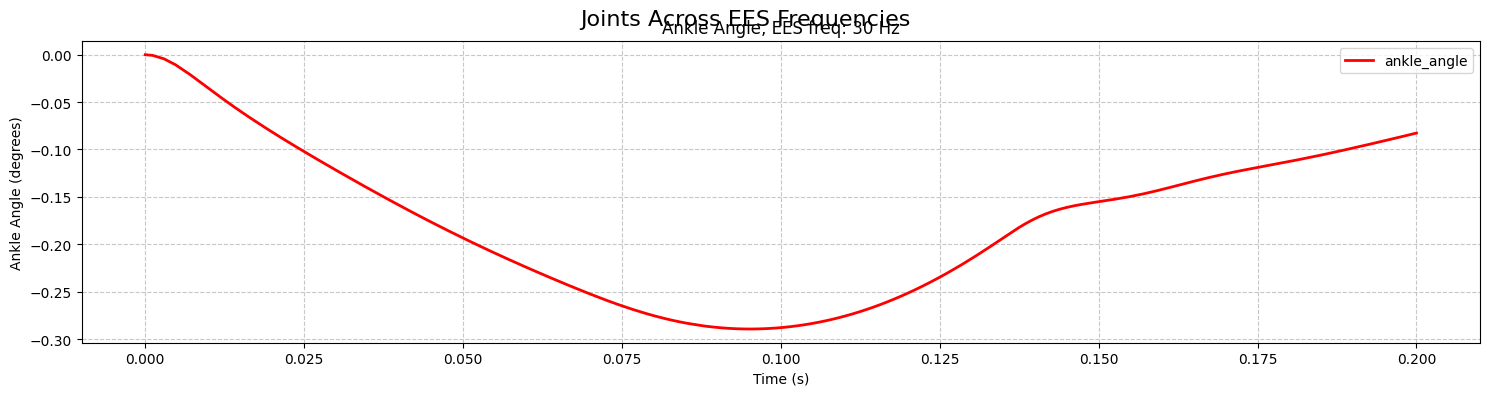

Simulation and plotting complete! All plots saved to 'frequency_analysis' directory.


ValueError: invalid literal for int() with base 10: 'Ia'

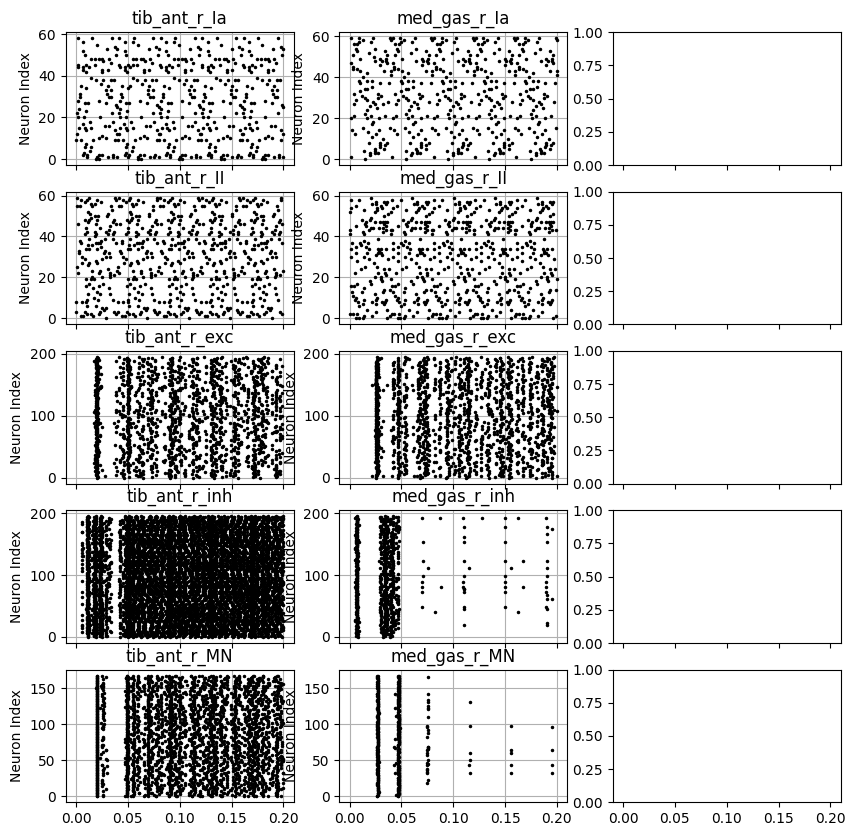

In [66]:
# Neural population parameters
NEURON_COUNTS = {
      "Ia": 60,       # Type Ia afferent neurons
      "II": 60,       # Type II afferent neurons
      "inh": 196,     # Inhibitory interneurons
      "exc": 196,     # Excitatory interneurons
      "motor": 169    # Motor neurons
}

EES_PARAMS = {
    'ees_freq': 0 * hertz,      # Frequency of epidural electrical stimulation
    'Ia_recruited': 60,     # Number of Ia fibers recruited
    'II_recruited': 60,     # Number of II fibers recruited
    'eff_recruited': 0       # Number of efferent fibers recruited
}


equation_Ia = "10+ 0.4*stretch + 0.86*sign(velocity)*abs(velocity)**0.6"
equation_II="20 + 3.375*stretch"

BIOPHYSICAL_PARAMS = {
    'T_refr': 2 * ms,  # Refractory period
    'noise_level': 0.2, #variability in the synpase weigth
    'Eleaky':-70*mV,
    'gL':10*nS,
    'Cm':0.3*nF,
    'E_ex':0*mV,
    'E_inh':-75*mV,
    'tau_e':0.5*ms,
    'tau_1':2*ms,
    'tau_2':4.5*ms,
    'threshold_v':-55*mV
}
CONNECTIONS = {
        ("Ia_flexor", "moto_flexor"): {"w":2*2.1*nS, "p": 0.9},
        ("Ia_flexor", "inh_flexor"): {"w":2*3.64*nS, "p": 0.9},
        ("Ia_extensor", "moto_extensor"): { "w": 2*2.1*nS, "p": 0.9},
        ("Ia_extensor", "inh_extensor"): {"w":2*3.64*nS, "p": 0.9},

        ("II_flexor", "exc_flexor"): {"w":2*1.65*nS, "p": 0.9},
        ("II_flexor", "inh_flexor"): {"w":2*2.19*nS, "p": 0.9},
        ("II_extensor", "exc_extensor"): {"w":2*1.65*nS, "p": 0.9},
        ("II_extensor", "inh_extensor"): {"w":2* 2.19*nS, "p": 0.9},

        ("exc_flexor", "moto_flexor"): {"w":2*0.7*nS, "p": 0.6},
        ("exc_extensor", "moto_extensor"): {"w":2*0.7*nS, "p": 0.6},

        ("inh_flexor", "moto_extensor"): {"w":2*0.2*nS,  "p": 0.9},
        ("inh_extensor", "moto_flexor"): {"w":2*0.2*nS, "p": 0.9},
        ("inh_flexor", "inh_extensor"): {"w":2*0.75*nS, "p": 0.5},
        ("inh_extensor", "inh_flexor"): {"w":2* 0.75*nS, "p": 0.5}
    }


MUSCLES_STR= "tib_ant_r,med_gas_r"  # Comma-separated muscle names
muscles_names=MUSCLES_STR.split(',')
num_muscles=len(muscles_names)

# Time parameters
REACTION_TIME = 40 * ms  # Duration of each simulation iteration
TIME_STEP = 0.1 * ms     # Simulation time step
N_ITERATIONS = 5      # Number of iterations
seed=41

# Create a directory for saving plots if it doesn't exist
save_dir = "frequency_analysis"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory '{save_dir}' for saving plots")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# EES frequencies to test
#EES_freq = np.arange(30, 90, 10)
EES_freq=[30]
time_series_to_plot = ['Ia_FR_theoretical', 'II_FR_theoretical', 'IPSP_inh', 'IPSP_moto', 'recruited_MN', 'MN_FR_monitored', 'mean_activation', 'stretch', 'joints']
n_rows = len(EES_freq)

# Initialize figures and axes
figs = {}
axs_dict = {}

for var in time_series_to_plot:
    fig, axs = plt.subplots(n_rows, 1, figsize=(15, 4 * n_rows), sharex=True)
    if n_rows == 1:
        axs = [axs]  # Ensure axs is always a list
    figs[var] = fig
    axs_dict[var] = axs

# Preallocate activities array
activities = None  # Will initialize inside loop
spikes={}
# Run simulations for each EES frequency
for i, freq in enumerate(EES_freq):
    # Set the current EES frequency
    EES_PARAMS['ees_freq'] = freq * hertz
    sto_name = f'All_opensim_' \
            f'Ia_{EES_PARAMS["Ia_recruited"]}_' \
            f'II_{EES_PARAMS["II_recruited"]}_' \
            f'Moto_{EES_PARAMS["eff_recruited"]}_' \
            f'Freq_{EES_PARAMS["ees_freq"]}_'\
            f'{timestamp}_'\
            f'{seed}.sto'
    sto_path = os.path.join(save_dir, sto_name)

    # --- Run simulation ---
    spikes, main_data= closed_loop(
        N_ITERATIONS, REACTION_TIME, TIME_STEP, EES_PARAMS, NEURON_COUNTS, CONNECTIONS,
        equation_Ia, equation_II, BIOPHYSICAL_PARAMS,
        MUSCLES_STR, sto_path, seed=seed
    )
    spikes[f"{freq}"]=spikes
    # Get time length for preallocation on first iteration
    if activities is None:
        T = len(main_data[0]['Time'])
        activities = np.zeros((len(muscles_names), n_rows, T))

    # --- Plot each variable except joints ---
    for var in [v for v in time_series_to_plot if v != 'joints']:
        # Get the axis for this variable and frequency
        ax = axs_dict[var][i]

        # Set title and labels before plotting
        ax.set_title(f"{var}, EES freq: {freq} Hz")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(var.replace('_', ' ').title())

        # Plot data for each muscle
        for idx, muscle_name in enumerate(muscles_names):
            if var in main_data[idx]:
                t = main_data[idx]['Time']
                y = main_data[idx][var]
                ax.plot(t, y, label=muscle_name)

                # Store mean activation
                if var == 'mean_activation':
                    activities[idx, i, :] = y

        # Add legend after all muscles are plotted
        ax.legend()

    # --- Plot joints separately ---
    joints=read_sto(sto_path,['ankle_angle_r'] )
    ax = axs_dict['joints'][i]
    ax.plot(joints['time'], joints['ankle_angle_r/value'], 'r-', label='ankle_angle', linewidth=2)
    ax.set_title(f"Ankle Angle, EES freq: {freq} Hz")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Ankle Angle (degrees)")
    ax.legend()

# --- Final layout adjustments, saving, and display ---

# Generate a timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Process all figures
for var in time_series_to_plot:
    # Add a main title to each figure
    figs[var].suptitle(f"{var.replace('_', ' ').title()} Across EES Frequencies", fontsize=16)

    # Make sure all plots have data and proper formatting
    for ax in axs_dict[var]:
        # If the axis is empty (no lines plotted), add a dummy invisible line
        if not ax.lines:
            ax.plot([0], [0], alpha=0)
            ax.text(0.5, 0.5, 'No data available',
                   horizontalalignment='center',
                   verticalalignment='center',
                   transform=ax.transAxes)

        # Ensure all axes have grids for better readability
        ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout
    figs[var].tight_layout()
    figs[var].subplots_adjust(top=0.9)

    # Create a meaningful filename
    # Format: variable_EESfreqs_timestamp.png
    var_name = var.replace('_', '-')
    freq_range = f"{min(EES_freq):.0f}to{max(EES_freq):.0f}Hz"
    filename = f"{var_name}_{freq_range}_{timestamp}_{seed}.png"
    filepath = os.path.join(save_dir, filename)

    # Save the figure with high resolution
    figs[var].savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {filename}")

# Display all figures
plt.show()

print(f"Simulation and plotting complete! All plots saved to '{save_dir}' directory.")

#plots raster plots
for freq in EES_freq:
    plot_raster(spikes[f"{freq}"],save_dir,**EES_PARAMS )

# ===== Flexor-Extensor Activation Analysis =====
print("\nPerforming flexor-extensor activation analysis...")

# Define activation threshold
activation_threshold = 0.1  # Threshold to consider a muscle as "active"

flexor_idx = 0  # tib_ant_r (tibialis anterior - flexor)
extensor_idx = 1  # med_gas_r (medial gastrocnemius - extensor)

# Create a figure for flexor vs extensor activity (scatterplot)
fig_scatter, axs_scatter = plt.subplots(1, len(EES_freq), figsize=(15, 5), squeeze=False)
fig_scatter.suptitle("Flexor vs Extensor Activity", fontsize=16)

# Create a figure for coactivation metrics
fig_coact, axs_coact = plt.subplots(1, 2, figsize=(15, 6))
fig_coact.suptitle("Coactivation Analysis", fontsize=16)

# Create a figure for activation time analysis
fig_time, axs_time = plt.subplots(1, 2, figsize=(15, 6))
fig_time.suptitle("Muscle Activation Time Analysis", fontsize=16)

# Arrays to store metrics across frequencies
min_coactivation = np.zeros(len(EES_freq))
product_coactivation = np.zeros(len(EES_freq))
flexor_active_time = np.zeros(len(EES_freq))
extensor_active_time = np.zeros(len(EES_freq))
total_time = main_data[0]['Time'].iloc[-1] # Total time in seconds

# Analyze each frequency
for i, freq in enumerate(EES_freq):
    # Get flexor and extensor activation data
    flexor_activation = activities[flexor_idx, i, :]
    extensor_activation = activities[extensor_idx, i, :]
    time_array = main_data[0]['Time']

    # Calculate time step for integration
    dt = time_array[1] - time_array[0] if len(time_array) > 1 else 0.001

    # 1. Flexor vs Extensor Scatter Plot
    ax = axs_scatter[0, i]
    ax.scatter(flexor_activation, extensor_activation, alpha=0.6, s=10)
    ax.set_xlabel("Flexor Activation")
    ax.set_ylabel("Extensor Activation")
    ax.set_title(f"EES Freq: {freq} Hz")
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add diagonal line for reference
    max_val = max(np.max(flexor_activation), np.max(extensor_activation))
    ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)

    # 2. Calculate coactivation metrics
    # Minimum-based coactivation: integral(min(flexor, extensor)dt)/total_time
    min_coact = np.sum(np.minimum(flexor_activation, extensor_activation)) * dt / total_time
    min_coactivation[i] = min_coact

    # Product-based coactivation: integral(flexor*extensor dt)/total_time
    prod_coact = np.sum(flexor_activation * extensor_activation) * dt / total_time
    product_coactivation[i] = prod_coact

    # 3. Calculate activation time (time above threshold)
    flexor_active = np.sum(flexor_activation > activation_threshold) * dt / total_time
    extensor_active = np.sum(extensor_activation > activation_threshold) * dt / total_time

    flexor_active_time[i] = flexor_active
    extensor_active_time[i] = extensor_active

# Plot coactivation metrics vs frequency
axs_coact[0].plot(EES_freq, min_coactivation, 'o-', linewidth=2)
axs_coact[0].set_xlabel("EES Frequency (Hz)")
axs_coact[0].set_ylabel("Min-based Coactivation")
axs_coact[0].set_title("Coactivation: min(flexor, extensor)")
axs_coact[0].grid(True)

axs_coact[1].plot(EES_freq, product_coactivation, 'o-', linewidth=2, color='orange')
axs_coact[1].set_xlabel("EES Frequency (Hz)")
axs_coact[1].set_ylabel("Product-based Coactivation")
axs_coact[1].set_title("Coactivation: flexor * extensor")
axs_coact[1].grid(True)

# Plot activation time metrics vs frequency
axs_time[0].plot(EES_freq, flexor_active_time, 'o-', linewidth=2, color='blue', label='Flexor')
axs_time[0].plot(EES_freq, extensor_active_time, 'o-', linewidth=2, color='green', label='Extensor')
axs_time[0].set_xlabel("EES Frequency (Hz)")
axs_time[0].set_ylabel("Fraction of Time Active")
axs_time[0].set_title(f"Time Active (threshold = {activation_threshold})")
axs_time[0].legend()
axs_time[0].grid(True)

# Plot activation time ratio (flexor/extensor)
ratio = np.divide(flexor_active_time, extensor_active_time,
                 out=np.ones_like(flexor_active_time),
                 where=extensor_active_time!=0)
axs_time[1].plot(EES_freq, ratio, 'o-', linewidth=2, color='purple')
axs_time[1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)  # Reference line at ratio=1
axs_time[1].set_xlabel("EES Frequency (Hz)")
axs_time[1].set_ylabel("Flexor/Extensor Ratio")
axs_time[1].set_title("Balance of Activation")
axs_time[1].grid(True)

# Adjust layout for all figures
for fig in [fig_scatter, fig_coact, fig_time]:
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

# Save these new figures
for fig, name in zip([fig_scatter, fig_coact, fig_time],
                    ["flexor_vs_extensor", "coactivation_metrics", "activation_time"]):
    filename = f"{name}_{min(EES_freq):.0f}to{max(EES_freq):.0f}Hz_{timestamp}_{seed}.png"
    filepath = os.path.join(save_dir, filename)
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved analysis plot: {filename}")

# Display all figures
plt.show()

print("Flexor-extensor activation analysis complete!")

